# Introduction
This is a Dataset for Stock Prediction on Apple Inc.
This dataset start from 1980 to 2022 . It was collected from Yahoo Finance. 
- Date: The date of the stock price record, providing a chronological timeline for the dataset.
- Open: The opening price, representing the initial trading price of Apple Inc.'s stock on a given day.
- High: The highest stock price during a specific period, providing insights into peak price levels.
- Low: The lowest stock price observed during a defined period, indicating potential fluctuations in value.
- Close: The closing price, representing the last recorded price at the end of a regular trading session.
- Adj Close (Adjusted Close): Adjusts the closing price for corporate actions, offering a more accurate representation of the stock's true value.
- Volume: Measures the number of shares traded, providing insights into interest and activity in Apple Inc.'s stock.

In [7]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [8]:
#load data
stock_df = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [3]:
stock_df.shape

(10468, 7)

In [28]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [29]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10468.000000,10468.000000,10468.000000,10468.000000,10468.000000,1.046800e+04
mean,14.757987,14.921491,14.594484,14.763533,14.130431,3.308489e+08
std,31.914174,32.289158,31.543959,31.929489,31.637275,3.388418e+08
min,0.049665,0.049665,0.049107,0.049107,0.038329,0.000000e+00
25%,0.283482,0.289286,0.276786,0.283482,0.235462,1.237768e+08
50%,0.474107,0.482768,0.465960,0.475446,0.392373,2.181592e+08
75%,14.953303,15.057143,14.692589,14.901964,12.835269,4.105794e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,7.421641e+09


In [30]:
#check for duplicates
stock_df.duplicated().sum()

0

In [31]:
#check nulls
stock_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [32]:
stock_df['Date'].max()

'2022-06-17'

# Exploratory Data Analysis (EDA)

In [9]:
#convert date to datetime 
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

Text(0.5, 0, 'Date')

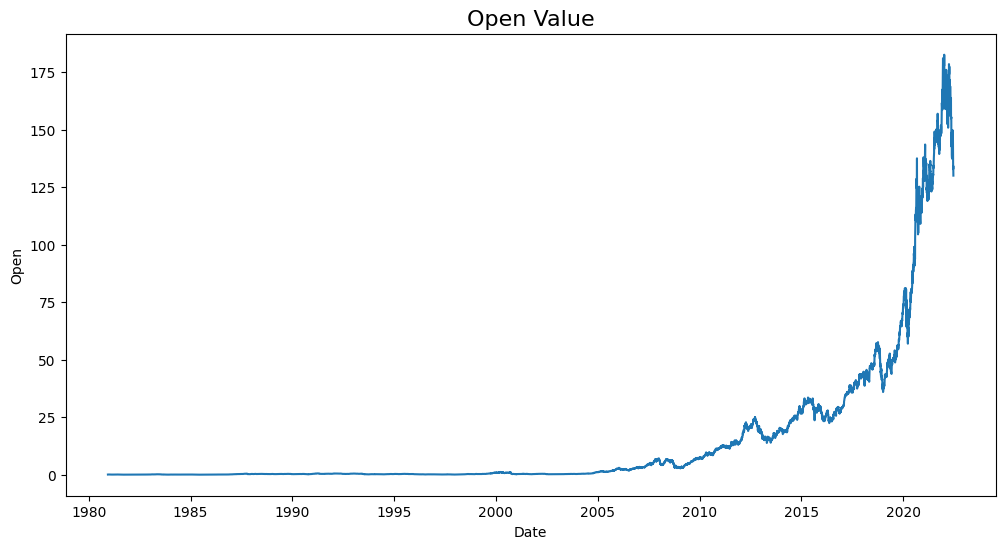

In [4]:
#plot Open column over time
plt.figure(figsize=[12,6])
sns.lineplot(data = stock_df, x = 'Date', y = 'Open');
plt.title('Open Value', fontsize =(16))
plt.xlabel('Date', fontsize=(10))

Text(0, 0.5, 'Close')

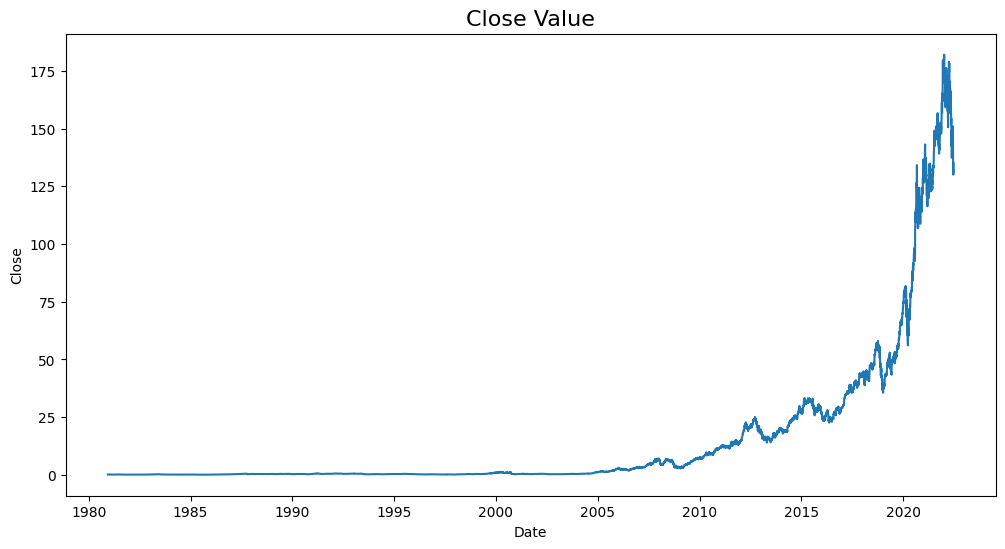

In [5]:
#plot Close column over time
plt.figure(figsize=[12,6])
sns.lineplot(data = stock_df, x = 'Date', y = 'Close');
plt.title('Close Value', fontsize =(16))
plt.xlabel('Date', fontsize=(10))
plt.ylabel('Close', fontsize=(10))

<Axes: title={'center': 'Correlation between variables'}>

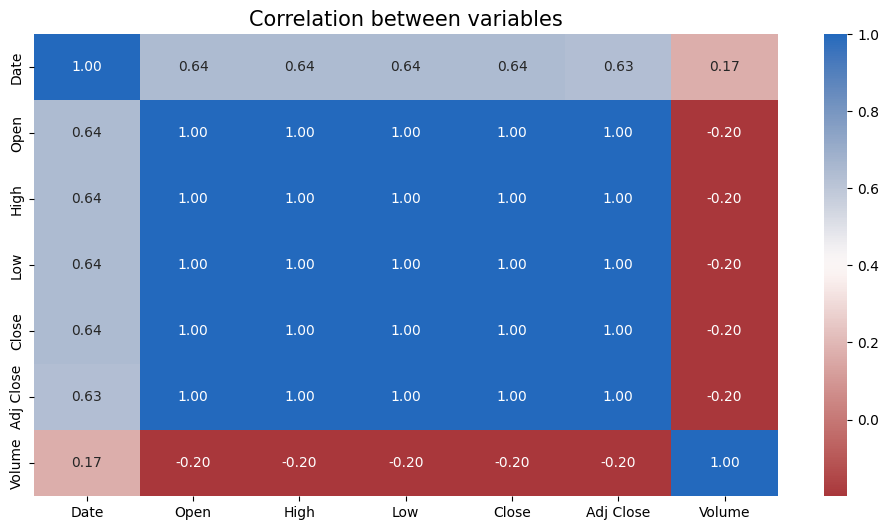

In [62]:
#correlation
plt.figure(figsize=[12,6])
plt.title('Correlation between variables', fontsize =(15))
sns.heatmap(stock_df.corr(), annot=True, fmt=".2f",  cmap = 'vlag_r')

# Prepare the data

In [6]:
X = stock_df[['Close']]

#sequence length
sequence_len = 200

#split the data
train_df = X.iloc[:8000].values
test_df = X.iloc[8000:].values

In [7]:
#scaling
scale = MinMaxScaler(feature_range=(0,1))
train_scale = scale.fit_transform(train_df)
test_scale = scale.transform(test_df)
print(train_scale.shape)
print(test_scale.shape)

(8000, 1)
(2468, 1)


In [8]:
#create sequence length for train data
X_train = []
y_train = []
for i in range(sequence_len, len(train_df)):
  X_train.append(train_scale[i-sequence_len:i, 0])
  y_train.append(train_scale[i, 0])

In [9]:
#convert lists to numpy arrays and reshape train data
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#create sequence length for test data
X_test = []
y_test = []

for i in range(sequence_len, len(test_df)):
  X_test.append(test_scale[i-sequence_len:i, 0])
  y_test.append(test_scale[i, 0])

#convert and reshape the test data
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model

In [10]:
#build lstm model
model = Sequential()

#adding 1st LSTM layer
model.add(LSTM(units = 100, return_sequences=False, input_shape=(X_train.shape[1], 1)))
#add dropout to avoid overfitting
model.add(Dropout(0.2))

#adding 2nd layer
# model.add(LSTM(units = 50, return_sequences=False))
# model.add(Dropout(0.2))

#output layer
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

#fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 35)

Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - loss: 0.0037 - val_loss: 1.3732
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - loss: 2.3367e-04 - val_loss: 1.1140
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 2.1534e-04 - val_loss: 0.7434
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 1.6977e-04 - val_loss: 0.8908
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - loss: 1.7002e-04 - val_loss: 0.5744
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - loss: 1.5183e-04 - val_loss: 0.4905
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - loss: 1.6695e-04 - val_loss: 0.6870
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 1.6547e-04 - val_loss: 0.4418
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - loss: 1.6085e-04 - val_loss: 0.5790
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - loss: 1.7960e-04 - val_loss: 0.3729
Epoch 11/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 1.5621e-0

# Generate Predictions

In [11]:
#get predictions on test data
prediction_output = model.predict(X_test)
print(f"y_test: {y_test.shape}")
print(f"predictions: {prediction_output.shape}")

test_data = pd.DataFrame(columns = ['test', 'predictions'])
test_data['test'] = y_test
test_data['predictions'] = prediction_output.flatten()
test_data

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
y_test: (2268,)
predictions: (2268, 1)


,test,predictions
0,0.638279,0.646303
1,0.625273,0.646470
2,0.616138,0.638444
3,0.611185,0.628152
4,0.594931,0.620146
...,...,...
2263,5.474177,4.959537
2264,5.510718,4.841271
2265,5.621588,4.849605
2266,5.398603,4.894084


# Visualizing Actual vs Predictions

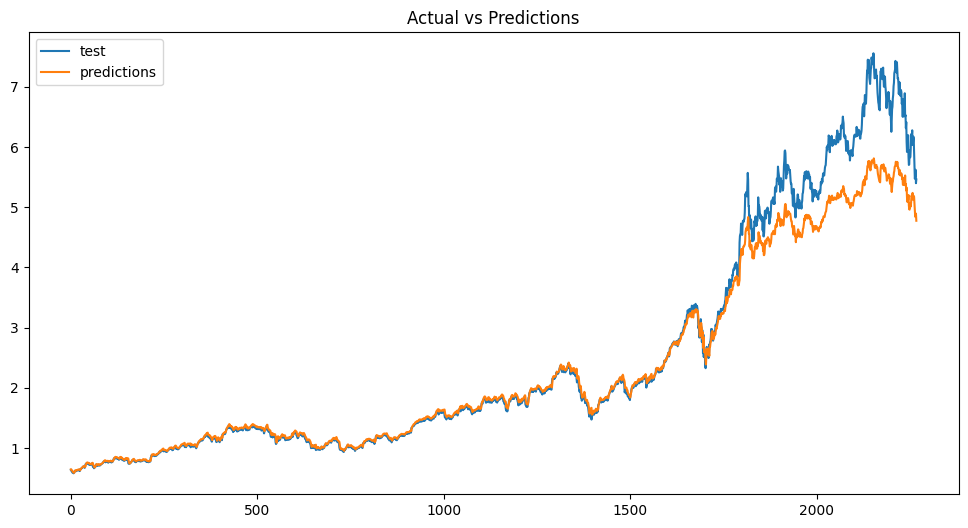

In [12]:
#plot Actual values vs predictions
plt.figure(figsize=[12,6])
plt.title('Actual vs Predictions', fontsize =(12))
plt.plot(test_data)
plt.legend(['test', 'predictions'])

# Model Evaluation

In [13]:
#evaluation metrics
mae = mean_absolute_error(y_test, prediction_output)
mse = mean_squared_error(y_test, prediction_output)
mape = mean_absolute_percentage_error(y_test, prediction_output)
r2 = r2_score(y_test, prediction_output)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.1892892043136999
Mean Absolute Error: 0.20777225589729645
Mean Absolute Percentage Error (MAPE): 4.58%
R² Score: 0.9467
